In [1]:
%load_ext autoreload
%autoreload 2

# Excited states with DANN (PaiNN + diabatization)
This tutorial gives an example of implementing the [equivariant PaiNN architecture](https://arxiv.org/pdf/2102.03150.pdf) for excited states. We'll use the diabatization method that forms the basis of the [DANN model](https://arxiv.org/pdf/2108.04879.pdf).

First we import dependencies for the tutorial:

In [2]:
import sys
from pathlib import Path

# so that NFF is in your path
sys.path.insert(0, "..")

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler


from nff.data import Dataset, split_train_validation_test, collate_dicts, to_tensor
from nff.train import Trainer, get_trainer, get_model, load_model, loss, hooks, metrics, evaluate

/home/dux/NeuralForceField/models


## Loss function

Let's make a loss function for the model. We'll use three diabatic states, so that the model outputs the six quantities `d_{ij}` for `i >= j`, and `0 <= i, j <= 2`. That means the model outputs `d_00`, `d_01`, etc. The model will then produce three adiabatic energies, `energy_{i}`. Last, the model will also run a backwards pass to produce the gradients `energy_{i}_grad`.

The loss function can penalize errors in the adiabatic energies and forces, adiabatic gaps, and non-adiabatic couplings (NACV). It can also penalize errors in the `d_{i}{i}`, provided that a set of reference geometries with known `d_{i}{i}` is in the dataset. 


The loss function can be created using a dictionary:

In [3]:
loss_dict = {
    "mse": [
        {"coef": 0.01, "params": {"key": "d_00"}},
        {"coef": 0.01, "params": {"key": "d_11"}},
        {"coef": 0.01, "params": {"key": "d_22"}},
        {"coef": 0.2, "params": {"key": "energy_0"}},
        {"coef": 1, "params": {"key": "energy_0_grad"}},
        {"coef": 0.1, "params": {"key": "energy_1"}},
        {"coef": 1, "params": {"key": "energy_1_grad"}},
        {"coef": 0.5, "params": {"key": "energy_1_energy_0_delta"}},
    ],
    "nacv": [{"coef": 1, "params": {"abs": False, "key": "force_nacv_10", "max": False}}],
}

We see that each key is a different type of loss (e.g. `mse` for mean-squared-error), and each value is a list of sub-dictionaries. Each sub-dictionary contains information about the quantities being penalized, through `params`, and their relative weights, through `coef`. For example, `d_11` is through with an MSE loss with weight 0.01. Some notes:

- The NACV gets its own special loss type, called `nacv`. This is because it must correct the phase of the predicted NACV to minimize the prediction error. This accounts for random sign changes in the ground truth NACV.

- Energy gaps in the dataset are denoted `energy_{i}_energy_{j}_delta`, where i > j.  

- Force NACVS in the dataset are denoted `force_nacv_{i}_energy_{j}_delta`, where i > j.  

Now we can supply the loss dictionary to `loss.build_multi_loss`, and we have our loss funnction:

In [4]:
loss_fn = loss.build_multi_loss(loss_dict)

## Making the model

Now let's make the actual model. To do this we can use `get_model`, together with the model parameters and model type. 

Our model type is called `PainnDiabat`, because it's PaiNN with diabatic states. We'll also have to supply the keys below, which include the regular hyperparameters (activation function, feature dimension, etc.), as well as the keys of the diabatic energies. We'll also specify `add_nacv=True`, which means the NACV will get computed when the model is called, and hence can be used in the loss function:


In [5]:
# Only provide the 6 unique diabatic keys
# It doesn't matter whether you use upper- or lower-triangular

diabat_keys = [["d_00", "d_01", "d_02"], ["d_01", "d_11", "d_12"], ["d_02", "d_12", "d_22"]]

modelparams = {
    "feat_dim": 128,
    "activation": "swish",
    "n_rbf": 20,
    "cutoff": 5.0,
    "num_conv": 3,
    "output_keys": ["energy_0", "energy_1"],
    "grad_keys": ["energy_0_grad", "energy_1_grad"],
    "diabat_keys": diabat_keys,
    "add_nacv": True,
}

model = get_model(modelparams, model_type="PainnDiabat")

## Optimizer, metrics, and hooks

Now we create the optimizer, metrics, and hooks, just like we do for regular models. For metrics we'll monitor the energies and forces of each state, as well as the gap:

In [6]:
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_metrics = [
    metrics.MeanAbsoluteError("energy_0"),
    metrics.MeanAbsoluteError("energy_1"),
    metrics.MeanAbsoluteError("energy_0_grad"),
    metrics.MeanAbsoluteError("energy_1_grad"),
    metrics.MeanAbsoluteError("energy_1_energy_0_delta"),
]


outdir = "sandbox_excited"
train_hooks = [
    hooks.CSVHook(
        outdir,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(outdir, metrics=train_metrics, separator=" | ", time_strf="%M:%S"),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        # patience in the original paper
        patience=50,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True,
    ),
]

## Dataset

The last thing we have to do before training is load the dataset. For the tutorial we have a pre-baked dataset saved in `data`. So all we have to do is load it, split it, and make data loaders:

In [7]:
dset = Dataset.from_file("data/azo_diabat.pth.tar")
train, val, test = split_train_validation_test(dset, val_size=0.1, test_size=0.1)

batch_size = 20
train_loader = DataLoader(train, batch_size=batch_size, collate_fn=collate_dicts, sampler=RandomSampler(train))

val_loader = DataLoader(val, batch_size=batch_size, collate_fn=collate_dicts)

test_loader = DataLoader(test, batch_size=batch_size, collate_fn=collate_dicts)

## Training

Now we're ready to train!

In [8]:
import shutil

if os.path.isdir(outdir):
    if os.path.isdir("backup"):
        shutil.rmtree("backup")
    shutil.move(outdir, "backup")

T = Trainer(
    model_path=outdir,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
    checkpoint_interval=1,
    hooks=train_hooks,
    mini_batches=1,
)

device = 3
T.train(device=device, n_epochs=200)

 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_1 | MAE_energy_0_grad | MAE_energy_1_grad | MAE_energy_1_energy_0_delta | GPU Memory (MB)


 98%|█████████▊| 39/40 [00:10<00:00,  3.90it/s]


39:00 |     1 |     1.000e-04 |  2409.8429 |       1765.8124 |      16.1016 |      21.4144 |           18.1311 |           16.6818 |                     12.0527 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.26it/s]


39:10 |     2 |     1.000e-04 |  1525.8175 |       1000.6619 |      10.9450 |      15.1935 |           12.0062 |           10.7199 |                     12.5809 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.24it/s]


39:20 |     3 |     1.000e-04 |   980.5403 |        785.6297 |      12.7098 |      13.4517 |           10.5978 |            9.1563 |                      8.7743 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.22it/s]


39:30 |     4 |     1.000e-04 |   809.7888 |        697.4660 |      11.6367 |      11.5051 |            9.8820 |            8.5186 |                      7.7984 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.18it/s]


39:40 |     5 |     1.000e-04 |   719.0159 |        609.7715 |       7.7871 |       7.6614 |            9.0678 |            7.8613 |                      8.5701 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.26it/s]


39:50 |     6 |     1.000e-04 |   654.0805 |        557.4868 |       7.4945 |       7.2096 |            8.6098 |            7.4778 |                      9.5453 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.23it/s]


40:00 |     7 |     1.000e-04 |   637.8794 |        584.8139 |      10.3903 |       6.9154 |            8.1887 |            7.1096 |                     13.2617 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.27it/s]


40:09 |     8 |     1.000e-04 |   560.9941 |        489.4879 |       6.9617 |       5.2608 |            7.4920 |            6.7539 |                      6.9125 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.19it/s]


40:19 |     9 |     1.000e-04 |   512.4817 |        492.4035 |       8.8427 |      11.4680 |            7.5346 |            6.4634 |                     10.2469 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.14it/s]


40:29 |    10 |     1.000e-04 |   515.0040 |        591.0896 |       9.9171 |      11.3521 |            7.0628 |            6.0835 |                     19.1943 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.22it/s]


40:39 |    11 |     1.000e-04 |   472.0274 |        415.6271 |       7.5144 |       5.1312 |            6.6429 |            5.9192 |                      6.3215 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.23it/s]


40:49 |    12 |     1.000e-04 |   508.1130 |        443.3791 |       6.4079 |       6.8611 |            6.7539 |            5.8211 |                     11.2140 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.22it/s]


40:59 |    13 |     1.000e-04 |   429.8747 |        403.4391 |       6.4424 |       4.4253 |            6.5356 |            5.6527 |                      6.5283 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.22it/s]


41:09 |    14 |     1.000e-04 |   408.2336 |        374.6719 |       9.6384 |       5.5618 |            6.1848 |            5.2632 |                      7.5984 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.20it/s]


41:19 |    15 |     1.000e-04 |   389.4094 |        384.4581 |       7.6033 |       5.5390 |            5.8545 |            5.1442 |                     11.3090 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.27it/s]


41:29 |    16 |     1.000e-04 |   382.8672 |        357.6686 |       5.9371 |       3.5544 |            6.0225 |            5.3100 |                      6.5698 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.17it/s]


41:39 |    17 |     1.000e-04 |   399.5306 |        403.1848 |       7.0356 |       8.3275 |            5.6324 |            5.0839 |                     13.7055 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.21it/s]


41:49 |    18 |     1.000e-04 |   365.4586 |        340.7988 |       5.6658 |       3.8232 |            5.6768 |            4.9820 |                      7.1074 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.24it/s]


41:59 |    19 |     1.000e-04 |  1091.6385 |        685.2732 |       8.3460 |      14.1881 |            9.1448 |            8.2842 |                     13.6369 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.23it/s]


42:08 |    20 |     1.000e-04 |   600.5755 |        474.5261 |       9.3657 |       5.6593 |            7.4312 |            6.2816 |                      7.9837 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.21it/s]


42:18 |    21 |     1.000e-04 |   456.0085 |        412.8279 |       6.6452 |       4.3176 |            6.5761 |            5.7220 |                      7.4280 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.23it/s]


42:28 |    22 |     1.000e-04 |   411.5912 |        378.9659 |       6.8403 |       3.9793 |            6.1933 |            5.4778 |                      6.5177 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.24it/s]


42:38 |    23 |     1.000e-04 |   375.9331 |        359.2948 |       7.6340 |       3.6288 |            5.9565 |            5.3113 |                      7.7126 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.77it/s]


42:49 |    24 |     1.000e-04 |   360.5073 |        340.0250 |       6.3817 |       3.3574 |            5.8212 |            5.1552 |                      6.9304 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.81it/s]


43:00 |    25 |     1.000e-04 |   340.6517 |        325.3750 |       5.7639 |       3.2513 |            5.7186 |            5.0302 |                      5.6499 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.66it/s]


43:11 |    26 |     1.000e-04 |   320.9279 |        286.3772 |       5.0788 |       3.0111 |            5.3397 |            5.0131 |                      4.6940 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.23it/s]


43:21 |    27 |     1.000e-04 |   326.8633 |        320.8649 |       7.1044 |       4.3324 |            5.4146 |            4.8666 |                      9.6832 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.22it/s]


43:31 |    28 |     1.000e-04 |   303.9450 |        261.3265 |       5.7573 |       3.2060 |            5.1516 |            4.7607 |                      5.3716 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.13it/s]


43:41 |    29 |     1.000e-04 |   265.5469 |        268.0131 |       3.8825 |       3.4031 |            5.1931 |            4.9771 |                      4.2493 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.27it/s]


43:51 |    30 |     1.000e-04 |   282.5686 |        295.9380 |       3.7920 |       3.9510 |            5.4125 |            5.1218 |                      4.7265 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.27it/s]


44:01 |    31 |     1.000e-04 |   238.5497 |        213.2060 |       4.3943 |       3.1441 |            4.7570 |            4.4766 |                      3.9485 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.15it/s]


44:11 |    32 |     1.000e-04 |   230.4590 |        203.3937 |       4.2783 |       3.2462 |            4.6698 |            4.4494 |                      3.2870 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.14it/s]


44:21 |    33 |     1.000e-04 |   307.7474 |        318.8843 |       4.9796 |       3.1132 |            5.6832 |            5.4986 |                      5.4501 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.20it/s]


44:31 |    34 |     1.000e-04 |   262.5834 |        213.8654 |       3.0715 |       3.9769 |            4.6854 |            4.5065 |                      3.7432 |               0


 98%|█████████▊| 39/40 [00:11<00:00,  3.54it/s]


44:42 |    35 |     1.000e-04 |   217.3859 |        216.8397 |       3.1112 |       6.1757 |            4.5086 |            4.3023 |                      6.6581 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.48it/s]


44:52 |    36 |     1.000e-04 |   234.2567 |        190.6681 |       3.0474 |       3.1111 |            4.4544 |            4.2584 |                      2.6379 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.14it/s]


45:02 |    37 |     1.000e-04 |   227.9605 |        248.8752 |       4.5994 |       6.3066 |            4.5608 |            4.2940 |                      9.5340 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.04it/s]


45:12 |    38 |     1.000e-04 |   254.5467 |        222.1551 |       3.9741 |       4.8561 |            4.5043 |            4.1997 |                      7.1563 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.02it/s]


45:22 |    39 |     1.000e-04 |   219.7022 |        199.3534 |       3.5763 |       3.6340 |            4.4054 |            4.2048 |                      4.7857 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.49it/s]


45:32 |    40 |     1.000e-04 |   206.5325 |        473.9445 |      11.9445 |       9.3779 |            4.7193 |            4.4219 |                     20.4864 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.32it/s]


45:41 |    41 |     1.000e-04 |   245.0261 |        166.8582 |       2.9656 |       3.1765 |            4.1597 |            3.9620 |                      2.3254 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.58it/s]


45:51 |    42 |     1.000e-04 |   209.9710 |        234.4076 |       3.3489 |       5.1370 |            4.6158 |            4.6012 |                      3.7295 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.28it/s]


46:00 |    43 |     1.000e-04 |   229.1237 |        198.5893 |       2.9990 |       4.1044 |            4.3940 |            4.2698 |                      2.8850 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.24it/s]


46:10 |    44 |     1.000e-04 |   204.4820 |        175.7422 |       3.7118 |       5.0974 |            4.2446 |            3.9864 |                      2.8018 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.50it/s]


46:19 |    45 |     1.000e-04 |   185.4262 |        229.1724 |       6.2227 |       3.2844 |            4.5074 |            4.2493 |                      6.6400 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.61it/s]


46:28 |    46 |     1.000e-04 |   191.9832 |        204.1853 |       5.6503 |       3.3863 |            4.4040 |            4.1926 |                      4.5897 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.26it/s]


46:38 |    47 |     1.000e-04 |   190.9798 |        205.6217 |       4.5454 |       3.3370 |            4.3319 |            4.1658 |                      5.6400 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.25it/s]


46:48 |    48 |     1.000e-04 |   197.2027 |        192.3034 |       3.2085 |       4.1368 |            4.3576 |            4.0520 |                      3.1081 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.42it/s]


46:57 |    49 |     1.000e-04 |   192.4188 |        165.7560 |       4.4255 |       4.7561 |            4.0867 |            3.9218 |                      2.1475 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.56it/s]


47:07 |    50 |     1.000e-04 |   189.0693 |        247.3832 |       7.6233 |       3.8215 |            4.3313 |            4.1575 |                      9.6616 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.64it/s]


47:16 |    51 |     1.000e-04 |   192.0749 |        190.1552 |       2.7507 |       4.2018 |            4.2611 |            4.1321 |                      3.4051 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.14it/s]


47:26 |    52 |     1.000e-04 |   194.5537 |        208.5701 |       2.5274 |       5.8691 |            4.3286 |            4.0183 |                      6.5384 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.48it/s]


47:35 |    53 |     1.000e-04 |   184.1678 |        180.4535 |       3.1186 |       5.9931 |            4.0934 |            4.0208 |                      4.1416 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.45it/s]


47:44 |    54 |     1.000e-04 |   276.6801 |        381.8862 |      17.2731 |      11.1160 |            4.9577 |            5.1658 |                     11.1925 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.48it/s]


47:54 |    55 |     1.000e-04 |   219.3056 |        166.0597 |       2.6357 |       3.1111 |            4.0024 |            3.9950 |                      2.4645 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.56it/s]


48:03 |    56 |     1.000e-04 |   206.4491 |        199.5748 |       3.0087 |       4.8828 |            4.1542 |            4.0128 |                      6.5666 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.57it/s]


48:12 |    57 |     1.000e-04 |   182.5371 |        151.1491 |       3.2050 |       3.5127 |            3.8328 |            3.8048 |                      2.0236 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.48it/s]


48:21 |    58 |     1.000e-04 |   197.9277 |        221.1849 |       4.4638 |      10.7514 |            4.1951 |            4.0388 |                      7.2660 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.64it/s]


48:30 |    59 |     1.000e-04 |   175.3749 |        147.6077 |       2.4280 |       2.6755 |            3.8357 |            3.7401 |                      2.1135 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.49it/s]


48:40 |    60 |     1.000e-04 |   181.6175 |        187.4718 |       8.3383 |       6.0704 |            4.1341 |            3.8910 |                      4.1074 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.42it/s]


48:49 |    61 |     1.000e-04 |   190.8689 |        185.9496 |       6.6703 |       4.7945 |            4.1073 |            3.9685 |                      4.3332 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.44it/s]


48:59 |    62 |     1.000e-04 |   218.2375 |        193.4122 |       3.2017 |       3.7400 |            4.2241 |            4.1620 |                      3.3479 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.37it/s]


49:08 |    63 |     1.000e-04 |   183.3165 |        195.4171 |       2.9609 |       2.8649 |            4.2146 |            4.1971 |                      2.3164 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.52it/s]


49:17 |    64 |     1.000e-04 |   168.1339 |        163.9012 |       2.6715 |       3.1904 |            3.9872 |            3.8056 |                      3.8478 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.33it/s]


49:27 |    65 |     1.000e-04 |   159.6719 |        156.9156 |       2.6339 |       3.8917 |            3.9292 |            3.7572 |                      2.7263 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.51it/s]


49:36 |    66 |     1.000e-04 |   169.3370 |        173.4122 |       5.0504 |       6.8037 |            3.9117 |            4.0094 |                      2.4981 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.56it/s]


49:45 |    67 |     1.000e-04 |   152.8590 |        134.6326 |       2.2017 |       2.5785 |            3.6974 |            3.5719 |                      1.7553 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.51it/s]


49:55 |    68 |     1.000e-04 |   154.7227 |        141.2028 |       2.4251 |       2.7768 |            3.7000 |            3.6355 |                      1.7392 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.87it/s]


50:05 |    69 |     1.000e-04 |   207.3097 |        155.9803 |       2.8716 |       3.3129 |            3.8897 |            3.7211 |                      1.9964 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.48it/s]


50:15 |    70 |     1.000e-04 |   153.5760 |        172.6897 |       5.4048 |       3.1636 |            3.7333 |            3.6790 |                      6.8407 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.55it/s]


50:24 |    71 |     1.000e-04 |   153.2487 |        157.6678 |       2.2833 |       4.0379 |            3.8021 |            3.7586 |                      4.5307 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.48it/s]


50:33 |    72 |     1.000e-04 |   156.4467 |        214.9171 |       2.2493 |       3.2667 |            4.3187 |            4.3731 |                      2.5604 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.59it/s]


50:42 |    73 |     1.000e-04 |   187.1334 |        169.4239 |       2.1251 |       5.8946 |            3.7553 |            3.7431 |                      5.8975 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.59it/s]


50:51 |    74 |     1.000e-04 |   150.7560 |        152.2188 |       2.3480 |       2.7115 |            3.8340 |            3.6916 |                      1.9213 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  3.95it/s]


51:02 |    75 |     1.000e-04 |   165.4016 |        151.0712 |       2.1295 |       3.4492 |            3.8374 |            3.6475 |                      3.3151 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  3.93it/s]


51:12 |    76 |     1.000e-04 |   162.1516 |        150.0389 |       3.8939 |       3.3031 |            3.7952 |            3.6673 |                      2.9852 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.58it/s]


51:24 |    77 |     1.000e-04 |   170.4560 |        172.2228 |       2.2021 |       6.5213 |            3.9087 |            3.7354 |                      5.8522 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.28it/s]


51:34 |    78 |     1.000e-04 |   146.5814 |        130.3033 |       2.1903 |       2.6349 |            3.6134 |            3.5493 |                      1.7759 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.57it/s]


51:43 |    79 |     1.000e-04 |   147.3884 |        148.1732 |       2.1263 |       2.5159 |            3.8162 |            3.6376 |                      2.0147 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.59it/s]


51:52 |    80 |     1.000e-04 |   147.3437 |        135.8490 |       4.1093 |       2.7260 |            3.6043 |            3.5287 |                      2.6723 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.06it/s]


52:02 |    81 |     1.000e-04 |   145.7931 |        124.1500 |       2.3338 |       2.4615 |            3.5136 |            3.4915 |                      1.8104 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.47it/s]


52:11 |    82 |     1.000e-04 |   154.2671 |        148.6110 |       2.2914 |       4.3046 |            3.7262 |            3.6690 |                      3.7184 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.56it/s]


52:21 |    83 |     1.000e-04 |   159.4878 |        170.6996 |       3.7734 |       3.2056 |            3.8230 |            3.7376 |                      5.9351 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.59it/s]


52:30 |    84 |     1.000e-04 |   152.0186 |        142.2927 |       2.1619 |       3.9975 |            3.7577 |            3.5220 |                      3.1854 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.09it/s]


52:40 |    85 |     1.000e-04 |   143.7898 |        143.6416 |       2.5762 |       2.9595 |            3.5511 |            3.5483 |                      4.0051 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.50it/s]


52:49 |    86 |     1.000e-04 |   151.9253 |        132.1561 |       3.0249 |       3.9400 |            3.5221 |            3.4998 |                      1.7855 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.75it/s]


53:00 |    87 |     1.000e-04 |   131.4365 |        212.1602 |       2.7366 |       3.6202 |            4.1330 |            4.2825 |                      2.4092 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.42it/s]


53:10 |    88 |     1.000e-04 |   167.3266 |        123.4052 |       2.1130 |       2.8428 |            3.4484 |            3.3880 |                      2.6157 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.00it/s]


53:20 |    89 |     1.000e-04 |   138.8089 |        138.8754 |       1.9540 |       3.7842 |            3.5823 |            3.6674 |                      3.4908 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.29it/s]


53:30 |    90 |     1.000e-04 |   138.8325 |        150.1188 |       2.2167 |       2.9550 |            3.7693 |            3.6464 |                      3.0231 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.50it/s]


53:39 |    91 |     1.000e-04 |   470.5148 |        407.7439 |       5.6033 |       4.6561 |            6.2470 |            5.2310 |                      7.1521 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.44it/s]


53:48 |    92 |     1.000e-04 |   361.0291 |        320.2904 |       5.1670 |       2.9488 |            5.2815 |            4.8196 |                      5.8911 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  3.99it/s]


53:59 |    93 |     1.000e-04 |   273.9070 |        220.9250 |       4.5948 |       2.9027 |            4.5229 |            4.0225 |                      4.0620 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.17it/s]


54:09 |    94 |     1.000e-04 |   214.2432 |        201.6687 |       5.0592 |       2.5451 |            4.2885 |            3.9620 |                      4.6909 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.24it/s]


54:19 |    95 |     1.000e-04 |   218.7501 |        295.4827 |       5.5930 |       3.9009 |            4.8967 |            4.7536 |                      4.0991 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.14it/s]


54:29 |    96 |     1.000e-04 |   227.4230 |        214.5625 |       3.5936 |       3.3707 |            4.4548 |            4.1868 |                      3.3584 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.30it/s]


54:39 |    97 |     1.000e-04 |   181.7777 |        207.1937 |       2.8600 |       6.5028 |            4.0710 |            3.7974 |                      7.6538 |               0


 98%|█████████▊| 39/40 [00:10<00:00,  3.90it/s]


54:49 |    98 |     1.000e-04 |   177.5896 |        177.1880 |       3.0910 |       2.9949 |            3.9188 |            3.7295 |                      4.7756 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.16it/s]


54:59 |    99 |     1.000e-04 |   164.8299 |        142.6875 |       2.9410 |       2.4481 |            3.5742 |            3.5357 |                      2.6593 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.63it/s]


55:08 |   100 |     1.000e-04 |   155.9944 |        137.0614 |       2.0664 |       2.3852 |            3.5886 |            3.5864 |                      1.9599 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.59it/s]


55:17 |   101 |     1.000e-04 |   152.5981 |        154.3207 |       2.3349 |       2.9826 |            3.7273 |            3.7145 |                      2.0386 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.52it/s]


55:27 |   102 |     1.000e-04 |   183.4130 |        157.7032 |       5.3484 |       4.9860 |            3.8346 |            3.7287 |                      2.9145 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.27it/s]


55:36 |   103 |     1.000e-04 |   231.4266 |        268.6326 |       5.1220 |       5.4092 |            4.5008 |            4.1010 |                      9.7148 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.28it/s]


55:46 |   104 |     1.000e-04 |   165.3401 |        122.6229 |       2.7160 |       3.4923 |            3.3826 |            3.3516 |                      1.7778 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.15it/s]


55:56 |   105 |     1.000e-04 |   162.6191 |        148.7692 |       2.2148 |       3.1351 |            3.5807 |            3.4958 |                      4.0761 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.58it/s]


56:05 |   106 |     1.000e-04 |   150.5837 |        148.1274 |       2.2240 |       2.7926 |            3.6668 |            3.6427 |                      1.9554 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.68it/s]


56:14 |   107 |     1.000e-04 |   146.8502 |        160.3827 |       2.5928 |       3.0731 |            3.7427 |            3.5931 |                      4.4050 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.60it/s]


56:23 |   108 |     1.000e-04 |   161.0063 |        132.6696 |       1.9633 |       2.9800 |            3.4656 |            3.3877 |                      2.3916 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.65it/s]


56:32 |   109 |     1.000e-04 |   150.1376 |        169.6842 |       2.2229 |       4.0725 |            3.8177 |            3.6156 |                      4.4033 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.63it/s]


56:41 |   110 |     1.000e-04 |   165.6455 |        161.1212 |       2.1364 |       5.6723 |            3.6259 |            3.5350 |                      5.1011 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.60it/s]


56:50 |   111 |     1.000e-04 |   154.5422 |        125.8817 |       2.7781 |       3.6810 |            3.3588 |            3.2714 |                      1.7968 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.64it/s]


56:59 |   112 |     1.000e-04 |   168.3118 |        222.2492 |       6.9321 |       4.0563 |            4.2537 |            4.0642 |                      4.3369 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.59it/s]


57:09 |   113 |     1.000e-04 |   164.5042 |        134.2838 |       1.9615 |       2.5230 |            3.4036 |            3.4491 |                      2.0367 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.50it/s]


57:18 |   114 |     1.000e-04 |   139.7190 |        127.5196 |       2.1576 |       2.6004 |            3.3937 |            3.3334 |                      1.7743 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.47it/s]


57:27 |   115 |     1.000e-04 |   150.2710 |        134.4713 |       2.1728 |       2.2912 |            3.4713 |            3.4155 |                      1.8088 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.35it/s]


57:37 |   116 |     1.000e-04 |   215.4453 |        172.3800 |       2.5631 |       2.8863 |            3.9807 |            3.7311 |                      3.6824 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.34it/s]


57:46 |   117 |     1.000e-04 |   153.5176 |        130.7563 |       3.4404 |       3.5161 |            3.3671 |            3.4502 |                      1.6071 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.27it/s]


57:56 |   118 |     1.000e-04 |   145.8503 |        181.1761 |       3.5028 |       3.4153 |            3.9066 |            3.9007 |                      2.2916 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.33it/s]


58:06 |   119 |     1.000e-04 |   143.7971 |        115.1291 |       3.8136 |       4.2654 |            3.2460 |            3.1250 |                      1.6339 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.21it/s]


58:16 |   120 |     1.000e-04 |   156.0735 |        154.0941 |       2.0638 |       2.2918 |            3.6326 |            3.6319 |                      1.9943 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.47it/s]


58:25 |   121 |     1.000e-04 |   193.6066 |        167.3837 |       3.8228 |       3.2592 |            3.6838 |            3.7258 |                      2.6764 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.30it/s]


58:35 |   122 |     1.000e-04 |   156.2954 |        167.0043 |       2.8429 |       2.8504 |            3.6476 |            3.7528 |                      2.1877 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.25it/s]


58:45 |   123 |     1.000e-04 |   161.1570 |        324.9387 |       4.1985 |       8.2236 |            4.5126 |            4.2539 |                     12.0346 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.24it/s]


58:54 |   124 |     1.000e-04 |   180.9944 |        129.3200 |       2.2470 |       2.7178 |            3.4156 |            3.3113 |                      1.7696 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.24it/s]


59:04 |   125 |     1.000e-04 |   137.7032 |        116.7276 |       2.0299 |       2.1951 |            3.2402 |            3.1743 |                      1.7241 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.27it/s]


59:14 |   126 |     1.000e-04 |   118.0441 |        112.0733 |       2.0356 |       2.0793 |            3.1502 |            3.1208 |                      1.7493 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.43it/s]


59:23 |   127 |     1.000e-04 |   151.0532 |        232.2513 |       2.3447 |       5.6269 |            4.1176 |            3.9735 |                      6.7544 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.32it/s]


59:33 |   128 |     1.000e-04 |   158.4685 |        128.4457 |       2.1534 |       3.4097 |            3.3528 |            3.3013 |                      2.1310 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.46it/s]


59:42 |   129 |     1.000e-04 |   138.3199 |        145.5163 |       3.7424 |       4.3736 |            3.4119 |            3.4765 |                      1.7677 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.67it/s]


59:51 |   130 |     1.000e-04 |   154.2433 |        210.0001 |       2.5081 |       3.8528 |            4.0495 |            3.8798 |                      5.5087 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.18it/s]


00:01 |   131 |     1.000e-04 |   150.1835 |        162.9709 |       2.3629 |       5.5973 |            3.5436 |            3.5026 |                      4.4655 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.24it/s]


00:11 |   132 |     1.000e-04 |   178.5726 |        136.3923 |       2.3560 |       2.4304 |            3.4449 |            3.4946 |                      1.7197 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.46it/s]


00:21 |   133 |     1.000e-04 |   149.2286 |        129.8462 |       2.0766 |       2.8668 |            3.3181 |            3.3033 |                      1.9726 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.54it/s]


00:30 |   134 |     1.000e-04 |   145.8872 |        128.3021 |       5.9160 |       5.6816 |            3.2545 |            3.3497 |                      1.7061 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.55it/s]


00:39 |   135 |     1.000e-04 |   124.4181 |        119.2524 |       1.8218 |       2.1985 |            3.2363 |            3.2163 |                      1.4650 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.49it/s]


00:48 |   136 |     1.000e-04 |   155.0198 |        149.0164 |       2.0524 |       3.5579 |            3.5747 |            3.4676 |                      3.8969 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.26it/s]


00:58 |   137 |     1.000e-04 |   153.3318 |        131.1860 |       3.2724 |       4.1837 |            3.3664 |            3.2897 |                      2.1067 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.45it/s]


01:07 |   138 |     1.000e-04 |   124.7377 |        127.6784 |       1.9425 |       2.5654 |            3.2441 |            3.2583 |                      2.3924 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.64it/s]


01:16 |   139 |     1.000e-04 |   153.8637 |        139.0596 |       2.3311 |       5.2568 |            3.3527 |            3.3042 |                      3.6453 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.36it/s]


01:26 |   140 |     1.000e-04 |   275.3968 |        339.4416 |       5.4430 |       5.4396 |            4.9189 |            4.5937 |                      9.3955 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.34it/s]


01:36 |   141 |     1.000e-04 |   241.5649 |        150.7755 |       2.2437 |       2.5586 |            3.5311 |            3.4955 |                      2.1024 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.63it/s]


01:45 |   142 |     1.000e-04 |   154.9115 |        171.0964 |       2.0591 |       5.0555 |            3.6431 |            3.5652 |                      4.8109 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.49it/s]


01:54 |   143 |     1.000e-04 |   169.0472 |        154.3732 |       4.3087 |       2.5589 |            3.5749 |            3.4937 |                      3.1380 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.57it/s]


02:03 |   144 |     1.000e-04 |   146.4968 |        141.1747 |       1.8270 |       2.5952 |            3.4748 |            3.4393 |                      1.9085 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.58it/s]


02:12 |   145 |     1.000e-04 |   130.1793 |        125.7883 |       1.9295 |       3.0038 |            3.2382 |            3.2160 |                      2.6395 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.29it/s]


02:22 |   146 |     1.000e-04 |   113.9405 |        119.3594 |       2.1657 |       2.4031 |            3.1745 |            3.1448 |                      1.7324 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.36it/s]


02:31 |   147 |     1.000e-04 |   140.4561 |        158.7176 |       1.9111 |       4.7201 |            3.5166 |            3.4070 |                      5.6178 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.59it/s]


02:40 |   148 |     1.000e-04 |   120.5938 |        131.8977 |       1.7829 |       2.2323 |            3.3284 |            3.2498 |                      1.7931 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.31it/s]


02:50 |   149 |     1.000e-04 |   135.6282 |        119.2219 |       1.8718 |       2.3744 |            3.2464 |            3.1991 |                      1.9085 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.25it/s]


03:00 |   150 |     1.000e-04 |   118.8691 |        187.2657 |       4.4495 |       2.4781 |            3.7701 |            3.5558 |                      5.1963 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.24it/s]


03:10 |   151 |     1.000e-04 |   131.0155 |        145.0017 |       5.7346 |       5.3151 |            3.3836 |            3.4552 |                      2.2221 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.48it/s]


03:19 |   152 |     1.000e-04 |   117.2743 |        126.6900 |       1.9093 |       2.1647 |            3.2784 |            3.2339 |                      1.6089 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.33it/s]


03:29 |   153 |     1.000e-04 |   106.4238 |        124.9900 |       4.6882 |       4.0984 |            3.1551 |            3.1781 |                      2.0702 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.19it/s]


03:39 |   154 |     1.000e-04 |   115.3151 |        112.8435 |       1.8002 |       2.2263 |            3.1152 |            3.0481 |                      1.5970 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.27it/s]


03:48 |   155 |     1.000e-04 |   132.8134 |        144.8889 |       2.9754 |       2.7738 |            3.5086 |            3.3408 |                      3.1299 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.26it/s]


03:58 |   156 |     1.000e-04 |   111.7059 |        114.8206 |       2.3661 |       3.8037 |            3.0411 |            3.0201 |                      2.0610 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.26it/s]


04:08 |   157 |     1.000e-04 |   120.0731 |        112.0067 |       2.0682 |       2.4721 |            3.0762 |            2.9578 |                      1.6498 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.38it/s]


04:18 |   158 |     1.000e-04 |   114.8466 |        100.6548 |       1.7624 |       2.1591 |            2.9397 |            2.9099 |                      1.8548 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.33it/s]


04:27 |   159 |     1.000e-04 |   115.4209 |        176.9217 |       2.3675 |       3.2387 |            3.6619 |            3.7070 |                      2.1974 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.15it/s]


04:37 |   160 |     1.000e-04 |   110.6758 |         99.2017 |       1.8527 |       2.1486 |            2.9382 |            2.9159 |                      1.5250 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.56it/s]


04:46 |   161 |     1.000e-04 |   245.7206 |       2131.5876 |      23.8164 |      28.6342 |            7.2853 |            7.5150 |                     51.6963 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.69it/s]


04:55 |   162 |     1.000e-04 |   661.4785 |        415.4818 |       7.3948 |       4.1871 |            6.1935 |            4.9749 |                      7.2681 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.64it/s]


05:04 |   163 |     1.000e-04 |   367.4600 |        292.7633 |       4.8108 |       2.7339 |            5.3118 |            4.6907 |                      5.3141 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.60it/s]


05:13 |   164 |     1.000e-04 |   255.0908 |        250.2316 |       3.5643 |       2.7778 |            4.9346 |            4.5170 |                      3.2953 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.53it/s]


05:23 |   165 |     1.000e-04 |   216.9837 |        305.1441 |       5.8596 |       6.6684 |            4.7880 |            4.2566 |                     11.2141 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.28it/s]


05:32 |   166 |     1.000e-04 |   213.0873 |        203.1906 |       4.1683 |       2.5012 |            4.3752 |            4.0148 |                      4.3100 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.34it/s]


05:42 |   167 |     1.000e-04 |   212.9947 |        176.4460 |       3.0214 |       3.1218 |            4.1134 |            3.7929 |                      3.6346 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.33it/s]


05:52 |   168 |     1.000e-04 |   223.7171 |        211.5925 |       5.5187 |       3.1104 |            4.3114 |            4.0627 |                      6.2955 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.24it/s]


06:02 |   169 |     1.000e-04 |   237.3834 |        231.5520 |       4.1534 |       5.9533 |            4.3084 |            3.8418 |                      9.0614 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.56it/s]


06:11 |   170 |     1.000e-04 |   197.9575 |        166.3264 |       3.3619 |       2.5873 |            4.0036 |            3.7275 |                      3.6557 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.44it/s]


06:20 |   171 |     1.000e-04 |   223.7394 |        150.1087 |       2.5924 |       2.4866 |            3.9008 |            3.6398 |                      2.3171 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.33it/s]


06:30 |   172 |     1.000e-04 |   191.6784 |        152.7462 |       2.8208 |       3.3043 |            3.8023 |            3.7554 |                      2.1666 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.57it/s]


06:39 |   173 |     1.000e-04 |   169.6100 |        144.9557 |       2.8597 |       2.5507 |            3.7428 |            3.5134 |                      3.2385 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.56it/s]


06:48 |   174 |     1.000e-04 |   147.6219 |        134.9148 |       2.0792 |       2.3854 |            3.5490 |            3.5440 |                      1.7869 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.58it/s]


06:57 |   175 |     1.000e-04 |   150.2516 |        141.2148 |       2.1541 |       2.3002 |            3.5962 |            3.4894 |                      1.8207 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.37it/s]


07:07 |   176 |     1.000e-04 |   221.8288 |        155.5292 |       2.4588 |       2.7959 |            3.8308 |            3.5389 |                      3.1721 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.33it/s]


07:16 |   177 |     1.000e-04 |   145.4202 |        203.5428 |       3.3597 |       2.9914 |            4.1722 |            3.8144 |                      5.0784 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.25it/s]


07:26 |   178 |     1.000e-04 |   158.9192 |        226.8418 |       2.9289 |       3.0511 |            4.3997 |            4.0884 |                      4.3585 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.43it/s]


07:36 |   179 |     1.000e-04 |   166.0480 |        152.7539 |       2.3902 |       3.1668 |            3.6714 |            3.4751 |                      3.8378 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.29it/s]


07:45 |   180 |     1.000e-04 |   156.8577 |        122.9319 |       2.3836 |       2.6124 |            3.4281 |            3.3128 |                      1.7178 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.45it/s]


07:55 |   181 |     1.000e-04 |   474.3168 |        256.6039 |       4.8448 |       2.6827 |            4.6315 |            4.2030 |                      6.1604 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.31it/s]


08:04 |   182 |     1.000e-04 |   241.8069 |        173.4902 |       3.2388 |       5.2961 |            4.0146 |            3.7191 |                      4.0014 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.22it/s]


08:14 |   183 |     1.000e-04 |   151.5530 |        162.6087 |       2.5944 |       3.4790 |            3.8122 |            3.5417 |                      4.6128 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.26it/s]


08:24 |   184 |     1.000e-04 |   197.5857 |        184.4684 |       4.4569 |       3.4041 |            3.8790 |            3.6711 |                      6.7674 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.47it/s]


08:33 |   185 |     1.000e-04 |   135.0740 |        124.0684 |       2.0906 |       2.2222 |            3.3866 |            3.3313 |                      1.7251 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.25it/s]


08:43 |   186 |     1.000e-04 |   135.0298 |        121.5804 |       2.1554 |       2.2601 |            3.4254 |            3.2185 |                      2.1262 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.22it/s]


08:53 |   187 |     1.000e-04 |   135.4948 |        140.6956 |       2.2796 |       2.3867 |            3.5790 |            3.4964 |                      1.8132 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.20it/s]


09:03 |   188 |     1.000e-04 |   194.4756 |        180.5686 |       3.1355 |       3.0630 |            4.0261 |            3.7775 |                      3.4912 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.51it/s]


09:12 |   189 |     1.000e-04 |   152.2249 |        129.7542 |       1.9933 |       2.2855 |            3.4934 |            3.4491 |                      1.7837 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.31it/s]


09:22 |   190 |     1.000e-04 |   143.9372 |        156.7764 |       2.1467 |       2.1485 |            3.7605 |            3.6277 |                      1.9829 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.62it/s]


09:31 |   191 |     1.000e-04 |   125.9439 |        161.1480 |       2.1649 |       2.0583 |            3.7814 |            3.6019 |                      2.1103 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.66it/s]


09:40 |   192 |     1.000e-04 |   134.3798 |        140.3515 |       2.0636 |       3.4053 |            3.5174 |            3.3011 |                      4.2850 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.62it/s]


09:49 |   193 |     1.000e-04 |   127.1906 |        125.9774 |       1.9651 |       2.0550 |            3.4009 |            3.3078 |                      1.6334 |               0


 98%|█████████▊| 39/40 [00:08<00:00,  4.57it/s]


09:58 |   194 |     1.000e-04 |   140.6975 |        228.9812 |       4.4515 |       6.4099 |            3.7897 |            3.5849 |                     10.5293 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.24it/s]


10:08 |   195 |     1.000e-04 |   142.4958 |        100.4472 |       1.9183 |       1.9647 |            3.1261 |            3.0264 |                      1.4646 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.27it/s]


10:18 |   196 |     1.000e-04 |   167.6880 |        200.3633 |       4.2454 |       3.5293 |            3.9883 |            3.6131 |                      6.9423 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.30it/s]


10:28 |   197 |     1.000e-04 |   157.8555 |        148.9546 |       2.1683 |       3.1609 |            3.6478 |            3.4104 |                      3.3463 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.26it/s]


10:37 |   198 |     1.000e-04 |   118.9579 |        111.7737 |       2.1581 |       1.8766 |            3.2340 |            3.0880 |                      2.0370 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.32it/s]


10:47 |   199 |     1.000e-04 |   116.4633 |        123.9797 |       1.7678 |       2.9582 |            3.3272 |            3.1848 |                      2.8283 |               0


 98%|█████████▊| 39/40 [00:09<00:00,  4.27it/s]


10:57 |   200 |     1.000e-04 |   110.5696 |        128.9663 |       1.9062 |       1.9193 |            3.3558 |            3.2793 |                      1.4895 |               0


## Evaluating

Lastly we'll evaluate the model on the test set. We'll also have to take special care of predicted and target NACVs by correcting the predicted NACV signs.

100%|██████████| 5/5 [00:00<00:00,  9.33it/s]


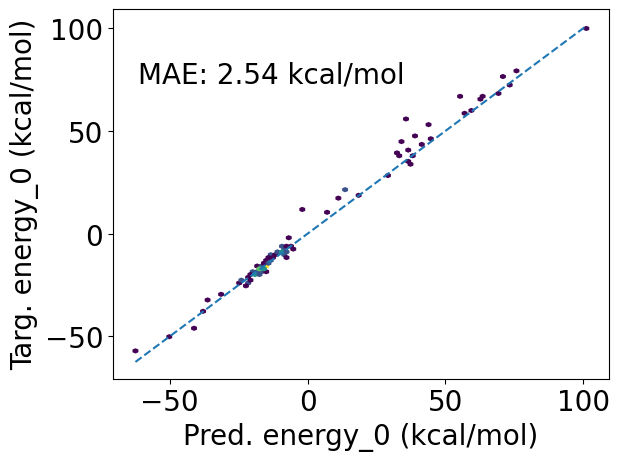

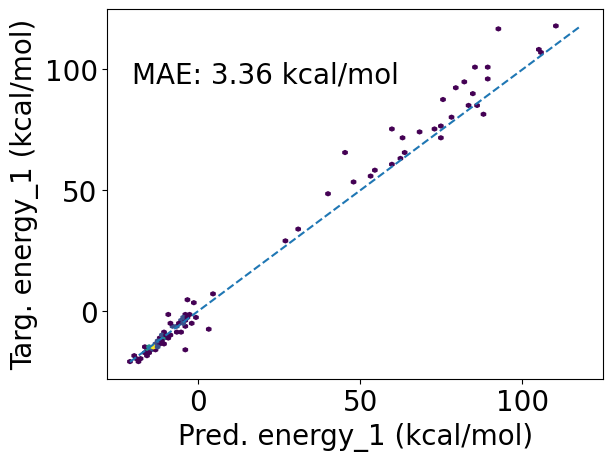

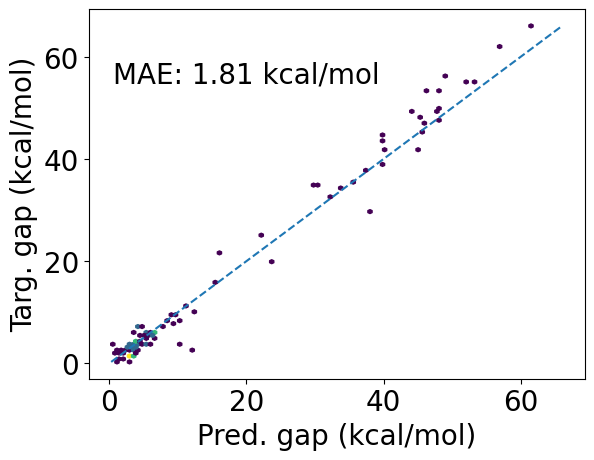

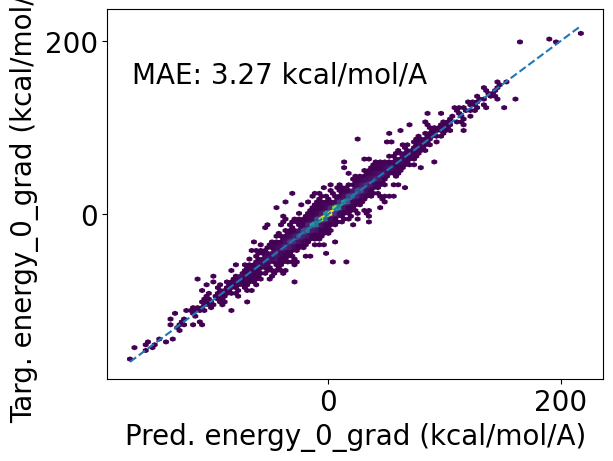

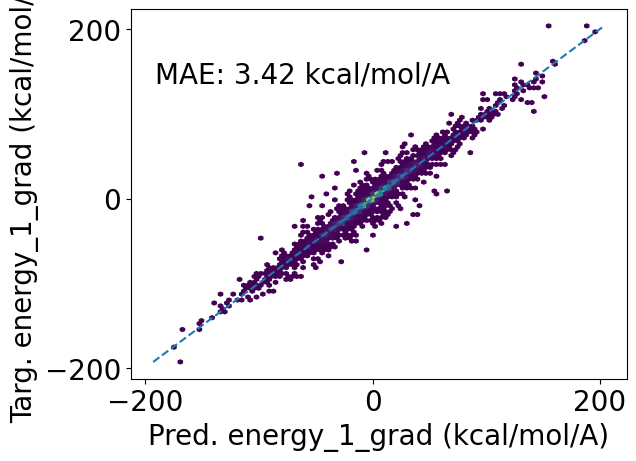

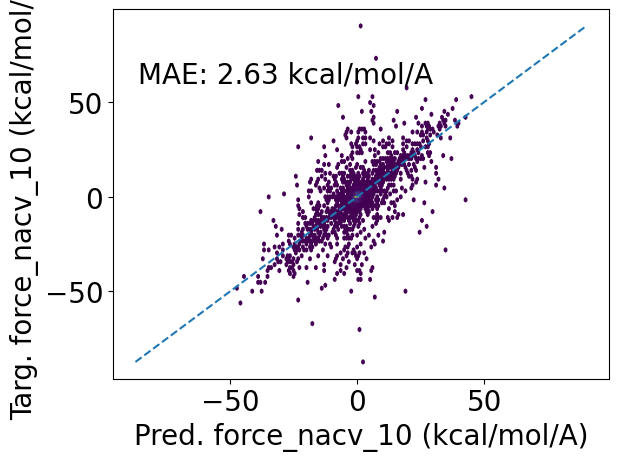

In [9]:
def correct_nacv(results, targets, key):
    num_atoms = targets["num_atoms"]
    if not isinstance(num_atoms, list):
        num_atoms = num_atoms.tolist()
    pred = torch.split(torch.cat(results[key]), num_atoms)
    targ = torch.split(torch.cat(targets[key]), num_atoms)

    real_pred = []

    for p, t in zip(pred, targ):
        sub_err = (p - t).abs().mean()
        add_err = (p + t).abs().mean()
        sign = 1 if sub_err < add_err else -1
        real_pred.append(sign * p)

    return real_pred


def plot(results, targets, key, units, name):
    pred = results[key]
    targ = targets[key]

    targ_dim = len(targets["energy_0"][0].shape)
    fn = torch.stack if targ_dim == 0 else torch.cat
    pred = torch.cat(pred).reshape(-1)
    targ = fn(targ).reshape(-1)

    mn = min([pred.min(), targ.min()])
    mx = max([pred.max(), targ.max()])
    ideal = np.linspace(mn, mx, 100)
    ideal = np.linspace(mn, mx, 100)

    mae = abs(pred - targ).mean()
    text = f"MAE: %.2f {units[key]}" % (mae)

    fig, ax = plt.subplots()
    plt.hexbin(pred, targ, mincnt=1)

    plt.xlabel(f"Pred. {name} ({units[key]})", fontsize=20)
    plt.ylabel(f"Targ. {name} ({units[key]})", fontsize=20)
    plt.text(0.05, 0.8, text, transform=ax.transAxes, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.locator_params(axis="x", nbins=4)
    plt.locator_params(axis="y", nbins=4)

    plt.plot(ideal, ideal, "--")

    plt.show()


results, targets, test_loss = evaluate(
    T.get_best_model(), test_loader, loss_fn=lambda x, y: torch.Tensor([0]), device=device
)
real_nacv = correct_nacv(results, targets, "force_nacv_10")
results["force_nacv_10"] = real_nacv


en_keys = ["energy_0", "energy_1", "energy_1_energy_0_delta"]
grad_keys = ["energy_0_grad", "energy_1_grad"]

units = {key: "kcal/mol" for key in en_keys}
units.update({key: "kcal/mol/A" for key in [*grad_keys, "force_nacv_10"]})

key_dic = {"energy_1_energy_0_delta": "gap"}

for key in [*en_keys, *grad_keys, "force_nacv_10"]:
    name = key_dic.get(key, key)
    plot(results, targets, key, units, name=name)

The model is off to a good start!